# Pneumonia

Original paper: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

They achieved 92.8% test accuracy, with 93.2% sensitivity, 90.1% specificity, and area under the ROC curve of 96.8%.

For binary comparison of bacterial vs. viral pneumonia they got 90.7% test accuracy with 88.6% sensitivity, 90.9% specificity and area under the ROC curve for distinguishing between the two of 94.0%.

## The Code

### Imports

First we import all of our libraries, mount our Google Drive and define our base directory (these last two are done according to whether or not we are running on a Google runtime or a local Jupyter Notebook runtime).

In [1]:
import torch  
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
from math import ceil

# Uncomment the following if the notebook is being run with Google Drive
# from google.colab import drive
# drive.mount('/content/drive/')
# BASE_DIR = '/content/drive/Shareddrives/WetLung'

# Uncomment the following if the notebook is being run locally
BASE_DIR = '.'


IMG_SIZE = (448, 448)
COLOR_DEPTH = 24

# As calculated in code later on
IMG_MEANS = (0.11999158, 0.118331894, 0.11863783)
IMG_STDS = (0.17364839, 0.17083007, 0.16970974)

### Quick Sanity Check

This small code chunk makes sure that we have hooked up runtime up with our data properly.  If all is well, an image of chest X-ray should be shown after running the code chunk.

<ipython-input-2-237e806c37ef>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axs[0, 0].imshow(torch.tensor((tfrm1(img).permute(1, 2, 0) * 255), dtype=int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<ipython-input-2-237e806c37ef>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axs[1, 0].imshow(torch.tensor((tfrm2(img).permute(1, 2, 0) * 255), dtype=int))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<ipython-input-2-237e806c37ef>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

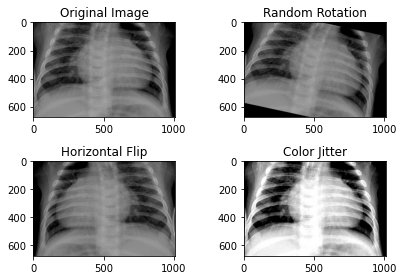

In [2]:
img = Image.open(BASE_DIR + '/chest_xray/train/PNEUMONIA/person530_bacteria_2233.jpeg')

jitter = 1.5

resz = transforms.Resize(IMG_SIZE)
tfrm1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])
tfrm2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=1),
    transforms.Normalize(0.5, 0.5)
])
tfrm3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(18),
    transforms.Normalize(0.5, 0.5)
])
tfrm4 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.ColorJitter((jitter, jitter), (jitter, jitter), (jitter, jitter))
])

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(torch.tensor((tfrm1(img).permute(1, 2, 0) * 255), dtype=int))
axs[0, 0].set_title("Original Image")
axs[1, 0].imshow(torch.tensor((tfrm2(img).permute(1, 2, 0) * 255), dtype=int))
axs[1, 0].set_title("Horizontal Flip")
axs[0, 1].imshow(torch.tensor((tfrm3(img).permute(1, 2, 0) * 255), dtype=int))
axs[0, 1].set_title("Random Rotation")
axs[1, 1].imshow(torch.tensor((tfrm4(img).permute(1, 2, 0) * 255), dtype=int))
axs[1, 1].set_title("Color Jitter")

plt.tight_layout()
plt.savefig("transforms.png", dpi=1000)
plt.show()

# plt.figure()
# plt.imshow(resz(img))

# plt.figure()
# plt.imshow(tfrm(img).permute(1, 2, 0))

# img.close()

### Data Pre-processing

This code chunk is a bit long, but it performs **all** of the data loading, manipulation, and saving that we'll need for the entire project, aside from the random pertubations made to training batches.

The code below has a 'safeguard' in place so that it only runs if the data relevant to the global *IMG_SIZE* and *COLOR_DEPTH* does not already exist.  This way we can *Run All Code Chunks* without worrying about running this chunk every time.  The code chunk *will* run and create new, relevant data if we decide to change the *IMG_SIZE* or *COLOR_DEPTH*, though.

The entirety of the operations performed by this chunk are the following:

1. Walk the */chest_xray/* path and gather all of the image file names.
2. All of our files are partitioned once by their membership to the train/test/validation split and then again by whether they are a normal chest X-ray or a pneumonia chest X-ray, so we generate our *y* variables from this.
3. One by one, convert each image to *COLOR_DEPTH*-bit color depth, resize the image to *IMG_SIZE*, and compile each of these transformed images into tensors.
4. Normalize each of the tensors that were built in step (3).
5. Shuffle each of the data splits.  (This part is unnecessary because of our use of PyTorch DataSets and DataLoaders later on, but we do it regardless.
6. Save all of the data to files.
7. Explicitly free the data as we have it stored now.  This clears up RAM that we will definitely be needing later.

In [3]:
# This function checks whether or not the data pertaining to the defined
# IMG_SIZE and COLOR_DEPTH already exists
def requisite_data_exists():
  for mode in ('train', 'test', 'val'):
    if not os.path.exists(BASE_DIR + '/numpy_objects/' + mode + '_X_' + str(IMG_SIZE[1]) + 'x' + str(IMG_SIZE[0]) + '_' + str(COLOR_DEPTH) + 'bit.npy'):
      return False
    elif not os.path.exists(BASE_DIR + '/torch_objects/' + mode + '_y.pt'):
      return False
    return True


# We *only* want to run this large chunk of data manipulation if the data we're 
# trying to generate does not already exist
if not requisite_data_exists():
  # Crude, but loads all of the files into separate arrays
  train_files = [glob.glob(BASE_DIR + '/chest_xray/train/' + pathend) for pathend in ['NORMAL/*.jpeg', 'PNEUMONIA/*.jpeg']]
  test_files = [glob.glob(BASE_DIR + '/chest_xray/test/' + pathend) for pathend in ['NORMAL/*.jpeg', 'PNEUMONIA/*.jpeg']]
  val_files = [glob.glob(BASE_DIR + '/chest_xray/val/' + pathend) for pathend in ['NORMAL/*.jpeg', 'PNEUMONIA/*.jpeg']]

  # Create emtpy arrs
  train_y = np.empty(len(train_files[0]) + len(train_files[1]))
  test_y = np.empty(len(test_files[0]) + len(test_files[1]))
  val_y = np.empty(len(val_files[0]) + len(val_files[1]))

  # Add the y's for the NORMALs
  train_y[0:len(train_files[0])] = 0
  test_y[0:len(test_files[0])] = 0
  val_y[0:len(val_files[0])] = 0

  # Cycle through the pneumonia files and add appropriately
  for name, i in zip(train_files[1], range(len(train_files[1]))):
    train_y[len(train_files[0]) + i] = 1 if "bacteria" in name else 2
  for name, i in zip(test_files[1], range(len(test_files[1]))):
    test_y[len(test_files[0]) + i] = 1 if "bacteria" in name else 2
  for name, i in zip(val_files[1], range(len(val_files[1]))):
    val_y[len(val_files[0]) + i] = 1 if "bacteria" in name else 2

  tfrms = transforms.Compose([
      transforms.Resize(IMG_SIZE),
      transforms.ToTensor()
  ])

  def transform(img):
    # The images vary in color depth so we convert all of them to RGB
    # with COLOR_DEPTH-bit color depth
    tfrm_img = tfrms(img.convert("RGB", colors=COLOR_DEPTH))
    img.close()
    return tfrm_img

  # We flatten the nested lists of files, load the images from the files, and convert the images to tensors all in one go
  print("Transforming train_X...")
  train_X = torch.empty((len(train_files[0]) + len(train_files[1]), 3, IMG_SIZE[0], IMG_SIZE[1]), dtype=torch.float32)
  for img, i in zip(np.concatenate(train_files), np.arange(len(train_files[0]) + len(train_files[1]))):
    train_X[i] = transform(Image.open(img))

  print("Transforming test_X...")
  test_X = torch.empty((len(test_files[0]) + len(test_files[1]), 3, IMG_SIZE[0], IMG_SIZE[1]), dtype=torch.float32)
  for img, i in zip(np.concatenate(test_files), np.arange(len(test_files[0]) + len(test_files[1]))):
    test_X[i] = transform(Image.open(img))

  print("Transforming val_X...")
  val_X = torch.empty((len(val_files[0]) + len(val_files[1]), 3, IMG_SIZE[0], IMG_SIZE[1]), dtype=torch.float32)
  for img, i in zip(np.concatenate(val_files), np.arange(len(val_files[0]) + len(val_files[1]))):
    val_X[i] = transform(Image.open(img))

  # Save our data
  print("Saving X data...")
  np.save(BASE_DIR + '/numpy_objects/train_X_' + str(IMG_SIZE[1]) + 'x' + str(IMG_SIZE[0]) + '_' + str(COLOR_DEPTH) + 'bit.npy', np.array(train_X), allow_pickle=True)
  np.save(BASE_DIR + '/numpy_objects/test_X_' + str(IMG_SIZE[1]) + 'x' + str(IMG_SIZE[0]) + '_' + str(COLOR_DEPTH) + 'bit.npy', np.array(test_X), allow_pickle=True)
  np.save(BASE_DIR + '/numpy_objects/val_X_' + str(IMG_SIZE[1]) + 'x' + str(IMG_SIZE[0]) + '_' + str(COLOR_DEPTH) + 'bit.npy', np.array(val_X), allow_pickle=True)

  print("Saving y data...")
  torch.save(torch.tensor(train_y, dtype=int), BASE_DIR + '/torch_objects/train_y.pt')
  torch.save(torch.tensor(test_y, dtype=int), BASE_DIR + '/torch_objects/test_y.pt')
  torch.save(torch.tensor(val_y, dtype=int), BASE_DIR + '/torch_objects/val_y.pt')

  # Clear out some memory so that we don't overload our RAM
  del train_X, test_X, val_X, train_y, test_y, val_y
  torch.cuda.empty_cache()
else:
  print('Requisite data already exists.')

Requisite data already exists.


In [4]:
  train_files = [glob.glob(BASE_DIR + '/chest_xray/train/' + pathend) for pathend in ['NORMAL/*.jpeg', 'PNEUMONIA/*.jpeg']]
  test_files = [glob.glob(BASE_DIR + '/chest_xray/test/' + pathend) for pathend in ['NORMAL/*.jpeg', 'PNEUMONIA/*.jpeg']]
  val_files = [glob.glob(BASE_DIR + '/chest_xray/val/' + pathend) for pathend in ['NORMAL/*.jpeg', 'PNEUMONIA/*.jpeg']]

  # Create emtpy arrs
  train_y = np.empty(len(train_files[0]) + len(train_files[1]))
  test_y = np.empty(len(test_files[0]) + len(test_files[1]))
  val_y = np.empty(len(val_files[0]) + len(val_files[1]))

  # Add the y's for the NORMALs
  train_y[0:len(train_files[0])] = 0
  test_y[0:len(test_files[0])] = 0
  val_y[0:len(val_files[0])] = 0

  # Cycle through the pneumonia files and add appropriately
  for name, i in zip(train_files[1], range(len(train_files[1]))):
    train_y[len(train_files[0]) + i] = 1 if "bacteria" in name else 2
  for name, i in zip(test_files[1], range(len(test_files[1]))):
    test_y[len(test_files[0]) + i] = 1 if "bacteria" in name else 2
  for name, i in zip(val_files[1], range(len(val_files[1]))):
    val_y[len(val_files[0]) + i] = 1 if "bacteria" in name else 2

In [5]:
print(sum(train_y == 0))
print(sum(train_y != 0))


1341
3875


### Mean and Standard Deviation

We calculate the mean and variance of our image data so that we can accurately normalize it later.

In [6]:
# We don't want to run this now because we've already done the calculations
if False:
  X = np.load(BASE_DIR + '/numpy_objects/' + 'train' + '_X_' + str(IMG_SIZE[1]) + 'x' + str(IMG_SIZE[0]) + '_' + str(COLOR_DEPTH) + 'bit.npy', mmap_mode='r', allow_pickle=True)
  c1 = X[:, :, :, 0]
  c2 = X[:, :, :, 1]
  c3 = X[:, :, :, 2]

  img_means = (c1.mean(), c2.mean(), c3.mean())
  img_stds  = (c1.std(), c2.std(), c3.std())

  print(img_means)
  print(img_stds)

  del X, c1, c2, c3

### Datasets

Here, we define an XrayDataset class which extends the PyTorch Dataset module.  Our main motivation for managing our data like this is that we need to load our data in a relatively unique way, and PyTorch Datasets allow us to do this in a very clean manner.

Our image data, even downscaled, is too large to fit in RAM all at once when we train our model.  To get around this (to an extent) we load our data into NumPy ndarrays with memory-mapping enabled.  This means that our data is never actually loaded into RAM *until it is accessed*.  This allows us to only load a batch of data into RAM at a time which we can then convert to a PyTorch tensor and give to our model to train.

In [7]:
class XrayDataset(Dataset):
  def __init__(self, mode, multi=False):
    self.X = np.load(BASE_DIR + '/numpy_objects/' + mode + '_X_' + str(IMG_SIZE[1]) + 'x' + str(IMG_SIZE[0]) + '_' + str(COLOR_DEPTH) + 'bit.npy', mmap_mode='r', allow_pickle=True)
    self.y = torch.load(BASE_DIR + '/torch_objects/' + mode + '_y.pt')

    if not multi:
      self.y[self.y == 2] = 1

    self.perspective_skew = 0.1
    self.crop_scale = 0.9
    self.horiz_flip_proba = 0.25

    self.output_size = (int((1 - self.perspective_skew) * self.crop_scale * IMG_SIZE[0]), int((1 - self.perspective_skew) * self.crop_scale * IMG_SIZE[1]))

    # If we're providing training data we want FULL data pertubations.
    # If we're providing ANY other type of data, we only want to return the data converted to Tensor form.
    if mode == 'train':
      self.tfrm = transforms.Compose([
          transforms.ToTensor(),
          transforms.RandomHorizontalFlip(p=self.horiz_flip_proba),
          transforms.RandomRotation(10),
          transforms.ColorJitter(0.7, 0.7, 0.7),
          transforms.Normalize(IMG_MEANS, IMG_STDS)
      ])

      #################################################################################################################################################
      # These transforms were used for all models before (excluding) model 9
      #
      # self.tfrm = transforms.Compose([
      #   # For some reason NumPy float32 arrays aren't handled by transforms.ToPILImage, so we have to convert to Tensor before we convert to PILImage
      #   transforms.ToTensor(),
      #   transforms.ToPILImage(),

      #   # Body orientations can be different during scans, so we don't want the model memorizing body orientations
      #   transforms.RandomPerspective(distortion_scale=self.perspective_skew, p=0.75, fill=150),
      #   transforms.RandomHorizontalFlip(p=self.horiz_flip_proba),
        
      #   # The center crop is to remove the majority of the black space left by the RandomPerspective transform
      #   transforms.CenterCrop(((1 - self.perspective_skew) * IMG_SIZE[0], (1 - self.perspective_skew) * IMG_SIZE[1])),

      #   # Finally we do a random crop so that the model doesn't memorize pixel positions or anything like that
      #   # We do 0.8 * IMG_SIZE, but this is really ~0.9 * IMG_SIZE when you take into account the rescaling that
      #   # happens naturally from the RandomPerspective transform
      #   transforms.RandomCrop(self.output_size),

      #   # Re-convert back to Tensor
      #   transforms.ToTensor()
      # ])
      ################################################################################################################################################
    else:
      # The normalization transform was added here with model 9
      self.tfrm = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(IMG_MEANS, IMG_STDS)
      ])

  def __len__(self):
   return self.y.size(0)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    if type(idx) == int:
      # We're only returning 1 index, so we return the transformed data
      ret_X = self.tfrm(self.X[idx].reshape(IMG_SIZE[0], IMG_SIZE[1], COLOR_DEPTH // 8))
    else:
      # idx is a list in this case, so we transform the NumPy data and then place it in a pre-allocated tensor
      ret_X = torch.empty((len(idx), COLOR_DEPTH // 8, self.output_size[0], self.output_size[1]))
      for i in range(ret_X.size(0)):
        ret_X[i] = self.tfrm(self.X[idx])

    return ret_X, self.y[idx]

### The Neural Model

Pretty basic convolutional neural networks.

In [8]:
class YOLOSigmoidModel(torch.nn.Module):
  def __init__(self, img_size):
    super(YOLOSigmoidModel, self).__init__()

    # Required 448x448 image size
    if img_size != (448, 448):
      raise ValueError("Image size must be 448x448 to use the YOLO model.")
    
    self.model_ID = 'YOLOSigmoid'

    # The network architecture from "You Only Look Once: Unified, Real-Time Object Detection"
    # https://arxiv.org/abs/1506.02640
    self.network = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(4, 4), stride=2),
        nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),

        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(2, 2), stride=1),
        nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1, 1), stride=1),
        nn.Sigmoid(),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(2, 2), stride=1),
        nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),

        nn.BatchNorm2d(256),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 1), stride=1),
        nn.Sigmoid(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(2, 2), stride=1),
        nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        
        nn.BatchNorm2d(256),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 1), stride=1, padding=1),
        nn.Sigmoid(),
        
        nn.BatchNorm2d(256),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(2, 2), stride=2, padding=1),
        nn.Sigmoid(),
        nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(1, 1), stride=1),
        nn.Sigmoid(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(2, 2), stride=2),
        nn.Sigmoid(),
        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(1, 1), stride=1),
        nn.Sigmoid(),

        nn.Flatten(),
        nn.BatchNorm1d(2048),
        
        nn.Linear(2048, 512),
        nn.Sigmoid(),

        nn.Linear(512, 1)
    )

  def forward(self, x):
    logits = self.network(x)
    return logits

In [9]:
class YOLOModel(torch.nn.Module):
  def __init__(self, img_size):
    super(YOLOModel, self).__init__()

    # Required 448x448 image size
    if img_size != (448, 448):
      raise ValueError("Image size must be 448x448 to use the YOLO model.")
    
    self.model_ID = 'YOLO'

    # The network architecture from "You Only Look Once: Unified, Real-Time Object Detection"
    # https://arxiv.org/abs/1506.02640
    self.network = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(4, 4), stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),

        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(2, 2), stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1, 1), stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(2, 2), stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),

        nn.BatchNorm2d(256),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 1), stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(2, 2), stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        
        nn.BatchNorm2d(256),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 1), stride=1, padding=1),
        nn.ReLU(),
        
        nn.BatchNorm2d(256),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(2, 2), stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(1, 1), stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(2, 2), stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(1, 1), stride=1),
        nn.ReLU(),

        nn.Flatten(),
        nn.BatchNorm1d(2048),
        
        nn.Linear(2048, 512),
        nn.ReLU(),

        nn.Linear(512, 1)
    )

  def forward(self, x):
    logits = self.network(x)
    return logits

In [10]:
class YOLOModelNoBatch(torch.nn.Module):
  def __init__(self, img_size):
    super(YOLOModelNoBatch, self).__init__()

    # Required 448x448 image size
    if img_size != (224, 224):
      raise ValueError("Image size must be 224x224 to use the YOLO model.")
    
    self.model_ID = 'YOLO_NoBatch'

    # The network architecture from "You Only Look Once: Unified, Real-Time Object Detection"
    # https://arxiv.org/abs/1506.02640
    self.network = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),

        nn.Conv2d(in_channels=64, out_channels=192, kernel_size=(3, 3), stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        
        nn.Conv2d(in_channels=192, out_channels=128, kernel_size=(1, 1), stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(2, 2), stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),

        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        
        nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=2, padding=1),
        nn.ReLU(),
        
        nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(1, 1), stride=1),
        nn.ReLU(),

        nn.Flatten(),

        nn.Linear(9216, 4096),
        nn.ReLU(),

        nn.Linear(4096, 1)
    )

  def forward(self, x):
    logits = self.network(x)
    return logits

In [11]:
class CNNModel1(torch.nn.Module):
  def __init__(self, img_size):
    super(CNNModel1, self).__init__()
    self.drop_proba = 0.5
    self.model_ID = '1'

    self.network = nn.Sequential(
        # Fully convolutional (not this network right now) reference paper: https://arxiv.org/pdf/1411.4038.pdf
        nn.Conv2d(3, 6, 8),
        nn.Conv2d(6, 12, 16),
        nn.MaxPool2d(4, 1),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        # nn.Dropout(self.drop_proba), try fitting model w/o dropout first, only add dropout once overfitting occurs
        nn.Conv2d(12, 18, 24),
        nn.MaxPool2d(3, 2),
        nn.BatchNorm2d(18),
        nn.ReLU(),
        # nn.Dropout(self.drop_proba),
        nn.Conv2d(18, 36, 24),
        nn.MaxPool2d(3, 2),
        nn.BatchNorm2d(36),
        nn.ReLU(),
        # nn.Dropout(self.drop_proba),
        nn.Flatten(),
        nn.Linear(17892, 1024),
        nn.ReLU(),
        nn.Dropout(self.drop_proba),
        nn.Linear(1024, 128),
        nn.ReLU(),
        nn.Dropout(self.drop_proba),
        nn.Linear(128, 1)
    )

  def forward(self, x):
    logits = self.network(x)
    return logits

In [12]:
class CNNModel2(torch.nn.Module):
  def __init__(self, img_size):
    super(CNNModel2, self).__init__()
    self.drop_proba = 0.4
    self.model_ID = '2'

    self.network = nn.Sequential(
        # Fully convolutional (not this network right now) reference paper: https://arxiv.org/pdf/1411.4038.pdf
        nn.Conv2d(3, 6, 8),
        nn.Conv2d(6, 12, 16),
        nn.MaxPool2d(4, 1),
        nn.Dropout(self.drop_proba),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout(self.drop_proba), # try fitting model w/o dropout first, only add dropout once overfitting occurs
        nn.Conv2d(12, 18, 24),
        nn.MaxPool2d(3, 2),
        nn.BatchNorm2d(18),
        nn.Dropout(self.drop_proba),
        nn.ReLU(),
        nn.Conv2d(18, 36, 24),
        nn.MaxPool2d(3, 2),
        nn.BatchNorm2d(36),
        nn.Dropout(self.drop_proba),
        nn.ReLU(),
        nn.Dropout(self.drop_proba),
        nn.Flatten(),
        nn.Linear(17892, 1024),
        nn.Dropout(self.drop_proba),
        nn.ReLU(),
        nn.Dropout(self.drop_proba),
        nn.Linear(1024, 128),
        nn.Dropout(self.drop_proba),
        nn.ReLU(),
        nn.Dropout(self.drop_proba),
        nn.Linear(128, 1)
    )

  def forward(self, x):
    logits = self.network(x)
    return logits

In [13]:
class CNNModel3(torch.nn.Module):
  def __init__(self, img_size):
    super(CNNModel3, self).__init__()
    self.drop_proba = 0.9
    self.model_ID = '3'

    self.network = nn.Sequential(
        # Fully convolutional (not this network right now) reference paper: https://arxiv.org/pdf/1411.4038.pdf
        nn.Conv2d(3, 6, 8),
        nn.Conv2d(6, 12, 16),
        nn.MaxPool2d(4, 1),
        nn.Dropout(self.drop_proba),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout(self.drop_proba), # try fitting model w/o dropout first, only add dropout once overfitting occurs
        nn.Conv2d(12, 18, 24),
        nn.MaxPool2d(3, 2),
        nn.BatchNorm2d(18),
        nn.Dropout(self.drop_proba),
        nn.ReLU(),
        nn.Conv2d(18, 36, 24),
        nn.MaxPool2d(3, 2),
        nn.BatchNorm2d(36),
        nn.Dropout(self.drop_proba),
        nn.ReLU(),
        nn.Dropout(self.drop_proba),
        nn.Flatten(),
        nn.Linear(17892, 1024),
        nn.Dropout(self.drop_proba),
        nn.ReLU(),
        nn.Dropout(self.drop_proba),
        nn.Linear(1024, 128),
        nn.Dropout(self.drop_proba),
        nn.ReLU(),
        nn.Dropout(self.drop_proba),
        nn.Linear(128, 1)
    )

  def forward(self, x):
    logits = self.network(x)
    return logits

In [14]:
class CNNModel4(torch.nn.Module):
  def __init__(self, img_size):
    super(CNNModel4, self).__init__()
    self.convolutional_drop_proba = 0.2
    self.linear_drop_proba = 0.2
    self.model_ID = '4'

    self.network = nn.Sequential(
        # ~very vaguely~ modeled off of the ResNet50 architecture, just without the Res part
        nn.Conv2d(3, 64, 7, stride=2),
        nn.MaxPool2d(3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 256, 1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout(self.convolutional_drop_proba),

        nn.Conv2d(256, 256, 3),
        nn.MaxPool2d(3, 2),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Dropout(self.convolutional_drop_proba),

        nn.AvgPool2d(3, padding=1),
        nn.Flatten(),

        nn.Linear(3584, 1024),
        nn.ReLU(),
        
        nn.Linear(1024, 1)
    )

  def forward(self, x):
    logits = self.network(x)
    return logits

In [15]:
class CNNModel5(torch.nn.Module):
  def __init__(self, img_size):
    super(CNNModel5, self).__init__()
    self.convolutional_drop_proba = 0.35
    self.linear_drop_proba = 0.35
    self.model_ID = '5'

    self.network = nn.Sequential(
        # ~very vaguely~ modeled off of the ResNet50 architecture, just without the Res part
        nn.Conv2d(3, 64, 7, stride=2),
        nn.MaxPool2d(3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 256, 1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout(self.convolutional_drop_proba),

        nn.Conv2d(256, 256, 3),
        nn.MaxPool2d(3, 2),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Dropout(self.convolutional_drop_proba),

        nn.AvgPool2d(3, padding=1),
        nn.Flatten(),

        nn.Linear(3584, 1024),
        nn.ReLU(),
        
        nn.Linear(1024, 1)
    )

  def forward(self, x):
    logits = self.network(x)
    return logits

In [16]:
class CNNModel6(torch.nn.Module):
  def __init__(self, img_size):
    super(CNNModel6, self).__init__()
    self.convolutional_drop_proba = 0.6
    self.linear_drop_proba = 0.35
    self.model_ID = '6'

    self.network = nn.Sequential(
        # ~very vaguely~ modeled off of the ResNet50 architecture, just without the Res part
        nn.Conv2d(3, 64, 7, stride=2),
        nn.MaxPool2d(3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 256, 1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout(self.convolutional_drop_proba),

        nn.Conv2d(256, 256, 3),
        nn.MaxPool2d(3, 2),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Dropout(self.convolutional_drop_proba),

        nn.AvgPool2d(3, padding=1),
        nn.Flatten(),

        nn.Linear(3584, 1024),
        nn.ReLU(),
        
        nn.Linear(1024, 1)
    )

  def forward(self, x):
    logits = self.network(x)
    return logits

In [17]:
class CNNModel7(torch.nn.Module):
  def __init__(self, img_size):
    super(CNNModel7, self).__init__()
    self.convolutional_drop_proba = 0.4
    self.linear_drop_proba = 0.25
    self.model_ID = '7'

    self.network = nn.Sequential(
        # ~very vaguely~ modeled off of the ResNet50 architecture, just without the Res part
        nn.Conv2d(3, 64, 7, stride=2),
        nn.MaxPool2d(3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Dropout(self.convolutional_drop_proba),

        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 256, 1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout(self.convolutional_drop_proba),

        nn.Conv2d(256, 256, 3),
        nn.MaxPool2d(3, 2),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Dropout(self.convolutional_drop_proba),

        nn.AvgPool2d(3, padding=1),
        nn.Flatten(),

        nn.Linear(3584, 1024),
        nn.Dropout(self.linear_drop_proba),
        nn.ReLU(),
        
        nn.Linear(1024, 1)
    )

  def forward(self, x):
    logits = self.network(x)
    return logits

In [18]:
class CNNModel8(torch.nn.Module):
  def __init__(self, img_size):
    super(CNNModel8, self).__init__()
    self.convolutional_drop_proba = 0.6
    self.linear_drop_proba = 0.5
    self.model_ID = '8'

    self.network = nn.Sequential(
        # ~very vaguely~ modeled off of the ResNet50 architecture, just without the Res part
        nn.Conv2d(3, 64, 7, stride=2),
        nn.MaxPool2d(3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Dropout(self.convolutional_drop_proba),

        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 256, 1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout(self.convolutional_drop_proba),

        nn.Conv2d(256, 256, 3),
        nn.MaxPool2d(3, 2),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Dropout(self.convolutional_drop_proba),

        nn.AvgPool2d(3, padding=1),
        nn.Flatten(),

        nn.Linear(1536, 512),
        nn.Dropout(self.linear_drop_proba),
        nn.ReLU(),
        
        nn.Linear(512, 1)
    )

  def forward(self, x):
    logits = self.network(x)
    return logits

In [19]:
class CNNModel9(torch.nn.Module):
  def __init__(self, img_size):
    super(CNNModel9, self).__init__()
    self.convolutional_drop_proba = 0.6
    self.linear_drop_proba = 0.5
    self.model_ID = '9'

    self.network = nn.Sequential(
        # ~very vaguely~ modeled off of the ResNet50 architecture, just without the Res part
        nn.Conv2d(3, 64, 7, stride=2),
        nn.MaxPool2d(3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Dropout2d(self.convolutional_drop_proba),

        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 256, 1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout2d(self.convolutional_drop_proba),

        nn.Conv2d(256, 256, 3),
        nn.MaxPool2d(3, 2),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Dropout(self.convolutional_drop_proba),

        nn.AvgPool2d(3, padding=1),
        nn.Flatten(),

        nn.Linear(3584, 512),
        nn.Dropout(self.linear_drop_proba),
        nn.ReLU(),
        
        nn.Linear(512, 1)
    )

  def forward(self, x):
    logits = self.network(x)
    return logits

### Model Training

Here we define a method to train a given model.  The main features to take note of here are the use of DataLoaders both for training and evaluation and the model checkpointing.

The more important of the two, the model checkpointing let's us save and run our models progressively in case our runtimes ever crash, or we end up having to shut down our computers early.  In this vain, we can also continue to track training and evaluation loss and accuracy by providing the saved arrays as arguments to the function.

In checkpointing, we only record the total number of epochs that we have gone through, but we still checkpoint the model at the end of each batch for an increased progress saving granularity.  This is especially important because single batches can take 10 minutes, which is progress we would rather not lose.

In [20]:
def train_binary_model(model, resume_training, num_epochs, train_dataloader, eval_dataloader, test_dataloader, optimizer, model_ID, resume_from=-1):
  # Set initial metric/save values
  train_cost=[]
  eval_cost=[]
  train_acc=[]
  eval_acc=[]
  test_cost=[]
  test_acc=[]
  model_dicts=[]
  opti_dicts=[]
  chkpt_epochs=0
  
  if resume_training:
    # Check if there is an applicable previous save
    if os.path.exists(BASE_DIR + '/torch_objects/model' +  model.model_ID + '.pt'):
      # Load the checkpoint
      checkpoint = torch.load(BASE_DIR + '/torch_objects/model' + model.model_ID + '.pt')

      # Reload the model/optimizer states
      model.load_state_dict(checkpoint['model_state_dicts'][resume_from])
      optimizer.load_state_dict(checkpoint['optimizer_state_dicts'][resume_from])

      # Reload everything else
      last = resume_from+1 if resume_from != 1 else resume_from
      train_cost = checkpoint['train_cost'][:last]
      eval_cost = checkpoint['eval_cost'][:last]
      train_acc = checkpoint['train_acc'][:last]
      eval_acc = checkpoint['eval_acc'][:last]
      test_cost = checkpoint['test_cost'][:last]
      test_acc = checkpoint['test_acc'][:last]
      test_cost = checkpoint['test_cost'][:last]
      model_dicts = checkpoint['model_state_dicts'][:last]
      opti_dicts = checkpoint['optimizer_state_dicts'][:last]
      chkpt_epochs = checkpoint['epoch'] if resume_from == -1 else resume_from

  for epoch in range(ceil(num_epochs - chkpt_epochs)):
    model.train()
    for i_batch, (batch_X, batch_y) in enumerate(train_dataloader):
      # Adjust batch_y to be binary
      batch_y[batch_y == 2] = 1
      batch_y = batch_y.view(-1, 1)

      # Forward pass
      logits = model.forward(batch_X)
      loss = F.binary_cross_entropy_with_logits(logits, batch_y.double())

      # Zero the gradients
      optimizer.zero_grad()

      # Backwards propogation
      loss.backward()

      # Print partial progress
      if not i_batch % 5:
        print('Epoch: %d/%d | Batch: %d/%d | Loss: %.3f' % (epoch+chkpt_epochs+1, num_epochs, i_batch+1, len(train_dataloader), loss.item()))

      # Update parameters
      optimizer.step()
      
    # Gather evaluation metrics
    model.eval()
    with torch.no_grad():
      # Record the training cost and accuracy
      temp_cost = temp_acc = 0
      for i_batch, (batch_X, batch_y) in enumerate(train_dataloader):
        # Adjust batch_y to be binary
        batch_y[batch_y == 2] = 1
        batch_y = batch_y.view(-1, 1)

        yhat = model.forward(batch_X)
        temp_cost += F.binary_cross_entropy_with_logits(yhat, batch_y.double()).item()
        temp_acc += torch.sum(torch.round(torch.sigmoid(yhat)) == batch_y).item()
      train_cost.append(temp_cost)
      train_acc.append(temp_acc / len(train_dataloader.dataset))
      print('Training accuracy: %.3f%%' % (train_acc[-1]*100))
      
      # Record the evaluation cost and accuracy
      temp_cost = temp_acc = 0
      for i_batch, (batch_X, batch_y) in enumerate(val_dataloader):
        # Adjust batch_y to be binary
        batch_y[batch_y == 2] = 1
        batch_y = batch_y.view(-1, 1)

        yhat = model.forward(batch_X)
        temp_cost += F.binary_cross_entropy_with_logits(yhat, batch_y.double()).item()
        temp_acc += torch.sum(torch.round(torch.sigmoid(yhat)) == batch_y).item()
      eval_cost.append(temp_cost)
      eval_acc.append(temp_acc / len(eval_dataloader.dataset))
      print('Validation accuracy: %.3f%%' % (eval_acc[-1]*100))

      # Record the test cost and accuracy
      temp_cost = temp_acc = 0
      for i_batch, (batch_X, batch_y) in enumerate(test_dataloader):
        # Adjust batch_y to be binary
        batch_y[batch_y == 2] = 1
        batch_y = batch_y.view(-1, 1)

        yhat = model.forward(batch_X)
        temp_cost += F.binary_cross_entropy_with_logits(yhat, batch_y.double()).item()
        temp_acc += torch.sum(torch.round(torch.sigmoid(yhat)) == batch_y).item()
      test_cost.append(temp_cost)
      test_acc.append(temp_acc / len(test_dataloader.dataset))
      print('Test accuracy: %.3f%%' % (test_acc[-1]*100))
    model.train()

    # Checkpoint the model
    model_dicts.append(model.state_dict().copy())
    opti_dicts.append(optimizer.state_dict().copy())
    torch.save({
        'model_state_dicts': model_dicts,
        'optimizer_state_dicts': opti_dicts,
        'epoch': epoch+chkpt_epochs+1,
        'train_cost': train_cost,
        'eval_cost': eval_cost,
        'train_acc': train_acc,
        'eval_acc': eval_acc,
        'test_cost': test_cost,
        'test_acc': test_acc
    }, BASE_DIR + '/torch_objects/model' + str(model_ID) + '.pt')

  return train_cost, eval_cost, train_acc, eval_acc

In [21]:
def train_multiclass_model(model, resume_training, num_epochs, train_dataloader, eval_dataloader, test_dataloader, optimizer):
  # Set initial metric/save values
  train_cost=eval_cost=train_acc=eval_acc=test_cost=test_acc=model_dicts=opti_dicts=[]
  chkpt_epochs=0
  
  if resume_training:
    # Check if there is an applicable previous save
    if os.path.exists(BASE_DIR + '/torch_objects/model' +  model.model_ID + '.pt'):
      # Load the checkpoint
      checkpoint = torch.load(BASE_DIR + '/torch_objects/model' + model.model_ID + '.pt')

      # Reload the model/optimizer states
      model.load_state_dict(checkpoint['model_state_dicts'][-1])
      optimizer.load_state_dict(checkpoint['optimizer_state_dicts'][-1])

      # Reload everything else
      train_cost = checkpoint['train_cost']
      eval_cost = checkpoint['eval_cost']
      train_acc = checkpoint['train_acc']
      eval_acc = checkpoint['eval_acc']
      test_cost = checkpoint['test_cost']
      test_acc = checkpoint['test_acc']
      model_dicts = checkpoint['model_state_dicts']
      opti_dicts = checkpoint['optimizer_state_dicts']
      chkpt_epochs = checkpoint['epoch']

  for epoch in range(ceil(num_epochs - chkpt_epochs)):
    model.train()
    for i_batch, (batch_X, batch_y) in enumerate(train_dataloader):
      # TODO: Make some random pertubations to the data before we train on it

      # Forward pass
      logits = model.forward(batch_X)
      loss = F.cross_entropy(logits, batch_y)

      # Zero the gradients
      optimizer.zero_grad()

      # Backwards propogation
      loss.backward()

      # Print partial progress
      if not i_batch % 5:
        print('Epoch: %d/%d | Batch: %d/%d | Loss: %.3f' % (epoch+chkpt_epochs+1, num_epochs, i_batch+1, len(train_dataloader), loss.item()))

      # Update parameters
      optimizer.step()
      
    # Gather evaluation metrics
    model.eval()
    with torch.no_grad():
      # Record the training cost and accuracy
      temp_cost = temp_acc = 0
      for i_batch, (batch_X, batch_y) in enumerate(train_dataloader):
        yhat = model.forward(batch_X)
        temp_cost += F.cross_entropy(yhat, batch_y).item()
        temp_acc += torch.sum(torch.argmax(yhat, dim=1) == batch_y).item()
      train_cost.append(temp_cost)
      train_acc.append(temp_acc / len(train_dataloader.dataset))
      print('Training accuracy: %.3f%%' % (train_acc[-1]*100))
      
      # Record the evaluation cost and accuracy
      temp_cost = temp_acc = 0
      for i_batch, (batch_X, batch_y) in enumerate(val_dataloader):
        yhat = model.forward(batch_X)
        temp_cost += F.cross_entropy(yhat, batch_y).item()
        temp_acc += torch.sum(torch.argmax(yhat, dim=1) == batch_y).item()
      eval_cost.append(temp_cost)
      eval_acc.append(temp_acc / len(eval_dataloader.dataset))
      print('Validation accuracy: %.3f%%' % (eval_acc[-1]*100))

      # Record the test cost and accuracy
      temp_cost = temp_acc = 0
      for i_batch, (batch_X, batch_y) in enumerate(test_dataloader):
        yhat = model.forward(batch_X)
        temp_cost += F.cross_entropy(yhat, batch_y).item()
        temp_acc += torch.sum(torch.argmax(yhat, dim=1) == batch_y).item()
      test_cost.append(temp_cost)
      test_acc.append(temp_acc / len(test_dataloader.dataset))
      print('Test accuracy: %.3f%%' % (test_acc[-1]*100))

    # Checkpoint the model
    model_dicts.append(model.state_dict().copy())
    opti_dicts.append(optimizer.state_dict().copy())
    torch.save({
        'model_state_dicts': model_dicts,
        'optimizer_state_dicts': opti_dicts,
        'epoch': epoch+chkpt_epochs+1,
        'train_cost': train_cost,
        'eval_cost': eval_cost,
        'train_acc': train_acc,
        'eval_acc': eval_acc,
        'test_cost': test_cost,
        'test_acc': test_acc
    }, BASE_DIR + '/torch_objects/model' + model.model_ID + '.pt')

    model.train()

  return train_cost, eval_cost, test_cost, train_acc, eval_acc, test_acc

Finally, all we have to do is set up our model and datasets and start training.

We also use this block of code to store notes regarding each of the models we've trained, how they performed, what we changed as we went along, etc.

In [1]:
# Build the datasets
batch_size = 128

train_dataset = XrayDataset('train')
val_dataset = XrayDataset('val')
test_dataset = XrayDataset('test')
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


# Train the models
 
# Model 1
# Note: starts massively overfitting after epoch 8, after epoch 7 though it had
# 89.8% training acc and 87.5% validation acc
# Could just be worth focusing on optimizing this model
#
# model = CNNModel1(IMG_SIZE)
# optimizer = torch.optim.Adam(model.parameters())

# Model 2
# somehow started overfitting faster than model 1, had 94% training acc and <60% val acc after epoch 2
#
# model = CNNModel2(IMG_SIZE)
# optimizer = torch.optim.Adam(model.parameters())

# Model 3
# This model got stuck @ 74% training accuracy and 50% eval accuracy,
# # Update to this note: turns out it's normal for the models to get stuck @ 74%/50%, so it may be worth running this model again
#
# model = CNNModel3(IMG_SIZE)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.99)

# Model 4
# First run through had 100% val accuracy on epoch 10, but we don't save ALL state dicts so we didn't get to keep that model
# Running again to try to reach that level of validation accuracy again
# #
# model = CNNModel4(IMG_SIZE) 
# optimizer = torch.optim.Adam(model.parameters())

# Model 5
# Model 4 had super good performance one time at epoch 10 as noted, but in later runs it started overfitting pretty quickly, so model 5
# is model 4 but with higher dropout probabilities
#
# Best validation acc was 87.5%, almost got 100% on training, i.e. overfit
#
# model = CNNModel5(IMG_SIZE)
# optimizer = torch.optim.Adam(model.parameters())

# Model 6
# Model 5 but w/ even higher dropout probs
#
# Still overfitting pretty quickly
#
# model = CNNModel6(IMG_SIZE)
# optimizer = torch.optim.Adam(model.parameters())

# Model 7
# This time we re-add a dropout layer to the fully connected portion of the architecture and increase the drop proba for the convolutional dropout layers
#
# model = CNNModel7(IMG_SIZE)
# optimizer = torch.optim.Adam(model.parameters())

# Model 8
# Model 7 was STILL overfitting so we're pumping the dropout probabilities wayyyyyyyyy up to see what happens
# If this overfits, we should try separately having only the linear and only the convolutional dropout probas high while the other is low
#
# One of the runs for this model had eval accuracy of 100%, so should check the test accuracy on that epoch's model
#
# model = CNNModel8(IMG_SIZE)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

################################################################################################################
# NOTE: ALL training done before this point was done WITHOUT applying random pertubations to the training data #
################################################################################################################

# Model 8, now with training sample pertubations
# model = CNNModel8(IMG_SIZE)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Model 9, changed Dropout layers that were next to Conv2d layers to Dropout2d
# model = CNNModel9(IMG_SIZE)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

################################################################################################################
# NOTE: ALL training done before this point was done wit the ORIGINAL train/test/val splits. Past this point,  #
#       some data was moved from test to val so that validation accuracies could be meaningfully interpretted. #
################################################################################################################

# YOLO model w/o batch norm, i.e. w/ ReLU, only running b/c the professor was curious about performance once activations are added
# model = YOLOModelNoBatch(IMG_SIZE)
# optimizer = torch.optim.Adam(model.parameters())


# YOLO model
# Funny enough, the first time I ran this model I totally forgot to put any activations in the convlutional layers
# and didn't put BatchNorms anywhere, but the model still got up to 99% training accuracy and >90% validation accuracy.
# These models were lost in an accidental file overwrite, but this is interesting to note.
# The model now includes ReLU activations and BatchNorms
#
# This model uses the newly calculated means/std's of the image data instead of 0.5 and 0.5 like other models used
#
# Ran into massive, fast overfitting issues with 224x224 images, but I think I remember 448x448 images not having as big of
# a problem with overfitting, so going back to that resolution
#
# Getting ~85% test acc on 448x448 is trivial, getting past that is very difficult though
# model = YOLOModel(IMG_SIZE)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

model = YOLOSigmoidModel(IMG_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# 100 epochs takes an enormous amount of time to get through, but we have checkpointing enabled, so who cares!
train_cost, eval_cost, train_acc, eval_acc = train_binary_model(model, False, 100, train_dataloader, val_dataloader, test_dataloader, optimizer, model.model_ID)

NameError: name 'XrayDataset' is not defined

In [ ]:
##############################################################################
# THIS CODE BLOCK IS SPECIFICALLY FOR GENERATING THE YOLOMODEL ACC/LOSS PLOT #
##############################################################################

# Testing the performance of the the best performing iteration of model 7
model = YOLOModel(IMG_SIZE)
optimizer = torch.optim.Adam(model.parameters())
checkpoint = torch.load(BASE_DIR + '/torch_objects/modelYOLO_first100.pt', map_location=torch.device('cpu'))

batch_size = 128

train_dataset = XrayDataset('train')
val_dataset = XrayDataset('val')
test_dataset = XrayDataset('test')
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

import matplotlib.pyplot as plt

plt.plot(range(len(checkpoint['train_acc'])), checkpoint['train_acc'], label="Training")
plt.plot(range(len(checkpoint['eval_acc'])), checkpoint['eval_acc'], label="Validation")
plt.plot(range(len(checkpoint['test_acc'])), checkpoint['test_acc'], label="Testing")

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.savefig("YOLOModel_first100_acc.png", dpi=1000)
plt.show()


adj_costs = torch.stack([torch.tensor(checkpoint['train_cost']) / len(train_dataloader), torch.tensor(checkpoint['eval_cost']) / len(val_dataloader), torch.tensor(checkpoint['test_cost']) / len(test_dataloader)])
adj_costs[range(0, 3, 2), 14:] /= 2
length = len(checkpoint['train_cost'])

plt.plot(range(length), adj_costs[0], label="Training")
plt.plot(range(length), adj_costs[1], label="Validation")
plt.plot(range(length), adj_costs[2], label="Testing")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.legend()
plt.savefig("YOLOModel_first100_loss.png", dpi=1000)
plt.show()

In [ ]:
##############################################################################
# THIS CODE BLOCK IS SPECIFICALLY FOR GENERATING THE YOLOMODEL ACC/LOSS PLOT #
##############################################################################

# Testing the performance of the the best performing iteration of model 7
model = YOLOModel(IMG_SIZE)
optimizer = torch.optim.Adam(model.parameters())
checkpoint = torch.load(BASE_DIR + '/torch_objects/modelYOLO-allReLU.pt', map_location=torch.device('cpu'))

batch_size = 32

train_dataset = XrayDataset('train')
val_dataset = XrayDataset('val')
test_dataset = XrayDataset('test')
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

import matplotlib.pyplot as plt

plt.plot(range(len(checkpoint['train_acc'])), checkpoint['train_acc'], label="Training")
plt.plot(range(len(checkpoint['eval_acc'])), checkpoint['eval_acc'], label="Validation")
plt.plot(range(len(checkpoint['test_acc'])), checkpoint['test_acc'], label="Testing")

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.savefig("YOLOModel_allReLU_acc.png", dpi=1000)
plt.show()


adj_costs = torch.stack([torch.tensor(checkpoint['train_cost']) / len(train_dataloader), torch.tensor(checkpoint['eval_cost']) / len(val_dataloader), torch.tensor(checkpoint['test_cost']) / len(test_dataloader)])
# adj_costs[range(0, 3, 2), 17:] /= 2
length = len(checkpoint['train_cost'])

plt.plot(range(length), adj_costs[0], label="Training")
plt.plot(range(length), adj_costs[1], label="Validation")
plt.plot(range(length), adj_costs[2], label="Testing")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.legend()
plt.savefig("YOLOModel_allReLU_loss.png", dpi=1000)
plt.show()

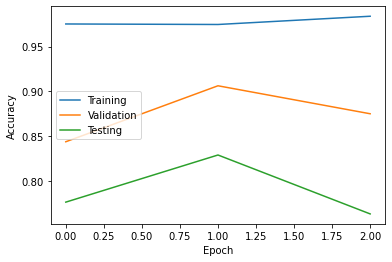

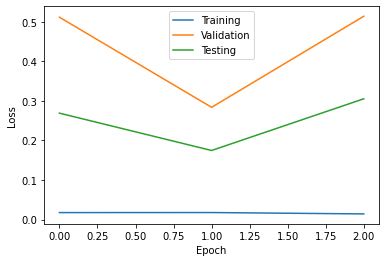

In [37]:
##############################################################################
# THIS CODE BLOCK IS SPECIFICALLY FOR GENERATING THE YOLOMODEL ACC/LOSS PLOT #
##############################################################################

# Testing the performance of the the best performing iteration of model 7
model = YOLOSigmoidModel(IMG_SIZE)
optimizer = torch.optim.Adam(model.parameters())
checkpoint = torch.load(BASE_DIR + '/torch_objects/modelYOLOSigmoid.pt', map_location=torch.device('cpu'))

batch_size = 32

train_dataset = XrayDataset('train')
val_dataset = XrayDataset('val')
test_dataset = XrayDataset('test')
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

import matplotlib.pyplot as plt

plt.plot(range(len(checkpoint['train_acc'])), checkpoint['train_acc'], label="Training")
plt.plot(range(len(checkpoint['eval_acc'])), checkpoint['eval_acc'], label="Validation")
plt.plot(range(len(checkpoint['test_acc'])), checkpoint['test_acc'], label="Testing")

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.savefig("YOLOModel_Sigmoid_acc.png", dpi=1000)
plt.show()


adj_costs = torch.stack([torch.tensor(checkpoint['train_cost']) / len(train_dataloader), torch.tensor(checkpoint['eval_cost']) / len(val_dataloader), torch.tensor(checkpoint['test_cost']) / len(test_dataloader)])
# adj_costs[range(0, 3, 2), 17:] /= 2
length = len(checkpoint['train_cost'])

plt.plot(range(length), adj_costs[0], label="Training")
plt.plot(range(length), adj_costs[1], label="Validation")
plt.plot(range(length), adj_costs[2], label="Testing")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.legend()
plt.savefig("YOLOModel_Sigmoid_loss.png", dpi=1000)
plt.show()

In [38]:
# Sens/spec of the all ReLU model

# Sensitivity: true positives / total positives
# Specificity: true negatives / total negatives

IMG_SIZE = (448, 448)

test_dataset = XrayDataset('test')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

model = YOLOModel(IMG_SIZE)
checkpoint = torch.load(BASE_DIR + '/torch_objects/modelYOLO-allReLU.pt', map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dicts'][76])

model.eval()

correct = 0
total = 0
true_neg = 0
true_pos = 0
total_pos = 0
total_neg = 0
for i_batch, (batch_X, batch_y) in enumerate(test_dataloader):
  yhat = torch.round(torch.sigmoid(model.forward(batch_X)))
  total += yhat.size(0)

  batch_y = torch.flatten(batch_y)
  y_compare = torch.flatten(yhat) == batch_y

  # Very inefficient calculation but we don't really care about that b/c these
  # calculations are incredibly fast compared to the speed of model.forward(...)
  correct += torch.sum(y_compare)
  true_pos += torch.sum(torch.logical_and(y_compare, batch_y == 1))
  total_pos += torch.sum(batch_y == 1)
  true_neg += torch.sum(torch.logical_and(y_compare, batch_y == 0))
  total_neg += torch.sum(batch_y == 0)

print('\nOverall test accuracy for model[%d]: %.3f%%' % (26, correct / total * 100))
print('Sensitivity: %.3f%%' % (true_pos / total_pos * 100))
print('Specificity: %.3f%%' % (true_neg / total_neg * 100))

KeyboardInterrupt: 

In [40]:
print(checkpoint['test_acc'][76])
print(checkpoint['train_acc'][76])
print(checkpoint['eval_acc'][76])

0.8651315789473685
0.9311733128834356
0.78125


In [43]:
# Sens/spec of the Sigmoid model

# Sensitivity: true positives / total positives
# Specificity: true negatives / total negatives

IMG_SIZE = (448, 448)

test_dataset = XrayDataset('test')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

model = YOLOSigmoidModel(IMG_SIZE)
checkpoint = torch.load(BASE_DIR + '/torch_objects/modelYOLOSigmoid.pt', map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dicts'][1])

model.eval()

correct = 0
total = 0
true_neg = 0
true_pos = 0
total_pos = 0
total_neg = 0
for i_batch, (batch_X, batch_y) in enumerate(test_dataloader):
  yhat = torch.round(torch.sigmoid(model.forward(batch_X)))
  total += yhat.size(0)

  batch_y = torch.flatten(batch_y)
  y_compare = torch.flatten(yhat) == batch_y

  # Very inefficient calculation but we don't really care about that b/c these
  # calculations are incredibly fast compared to the speed of model.forward(...)
  correct += torch.sum(y_compare)
  true_pos += torch.sum(torch.logical_and(y_compare, batch_y == 1))
  total_pos += torch.sum(batch_y == 1)
  true_neg += torch.sum(torch.logical_and(y_compare, batch_y == 0))
  total_neg += torch.sum(batch_y == 0)

print('\nOverall test accuracy for model[%d]: %.3f%%' % (26, correct / total * 100))
print('Sensitivity: %.3f%%' % (true_pos / total_pos * 100))
print('Specificity: %.3f%%' % (true_neg / total_neg * 100))

KeyboardInterrupt: 

In [44]:
print(checkpoint['test_acc'][26])
print(checkpoint['train_acc'][26])
print(checkpoint['eval_acc'][26])

IndexError: list index out of range

In [41]:
# Sens/spec of the not all ReLU model

# Sensitivity: true positives / total positives
# Specificity: true negatives / total negatives

class YOLOModelNotAll(torch.nn.Module):
  def __init__(self, img_size):
    super(YOLOModelNotAll, self).__init__()

    # Required 448x448 image size
    if img_size != (448, 448):
      raise ValueError("Image size must be 448x448 to use the YOLO model.")
    
    self.model_ID = 'YOLO'

    # The network architecture from "You Only Look Once: Unified, Real-Time Object Detection"
    # https://arxiv.org/abs/1506.02640
    self.network = nn.Sequential(
        nn.BatchNorm2d(3),
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(4, 4), stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),

        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(2, 2), stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1, 1), stride=1),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(2, 2), stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),

        nn.BatchNorm2d(256),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 1), stride=1),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(2, 2), stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        
        nn.BatchNorm2d(256),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 1), stride=1, padding=1),
        nn.ReLU(),
        
        nn.BatchNorm2d(256),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(2, 2), stride=2, padding=1),
        nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(1, 1), stride=1),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(2, 2), stride=2),
        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(1, 1), stride=1),
        nn.ReLU(),

        nn.Flatten(),
        nn.BatchNorm1d(2048),
        
        nn.Linear(2048, 512),
        nn.ReLU(),

        nn.Linear(512, 1)
    )

  def forward(self, x):
    logits = self.network(x)
    return logits

IMG_SIZE = (448, 448)

test_dataset = XrayDataset('test')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

model = YOLOModelNotAll(IMG_SIZE)
checkpoint = torch.load(BASE_DIR + '/torch_objects/modelYOLO_first100.pt', map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dicts'][26])

model.eval()

correct = 0
total = 0
true_neg = 0
true_pos = 0
total_pos = 0
total_neg = 0
for i_batch, (batch_X, batch_y) in enumerate(test_dataloader):
  yhat = torch.round(torch.sigmoid(model.forward(batch_X)))
  total += yhat.size(0)

  batch_y = torch.flatten(batch_y)
  y_compare = torch.flatten(yhat) == batch_y

  # Very inefficient calculation but we don't really care about that b/c these
  # calculations are incredibly fast compared to the speed of model.forward(...)
  correct += torch.sum(y_compare)
  true_pos += torch.sum(torch.logical_and(y_compare, batch_y == 1))
  total_pos += torch.sum(batch_y == 1)
  true_neg += torch.sum(torch.logical_and(y_compare, batch_y == 0))
  total_neg += torch.sum(batch_y == 0)

print('\nOverall test accuracy for model[%d]: %.3f%%' % (26, correct / total * 100))
print('Sensitivity: %.3f%%' % (true_pos / total_pos * 100))
print('Specificity: %.3f%%' % (true_neg / total_neg * 100))

KeyboardInterrupt: 

In [42]:
print(checkpoint['test_acc'][26])
print(checkpoint['train_acc'][26])
print(checkpoint['eval_acc'][26])

0.8536184210526315
0.888420245398773
0.8125


In [ ]:
torch.logical_and(torch.flatten(yhat) == torch.flatten(batch_y), torch.flatten(batch_y) == 1)

In [ ]:
# Our model has high sensitivity but low specificity, so let's train again starting from our best epoch,
# but this time we'll use weighted sampling w/ pneumonia positive samples having double the weight of negatives

batch_size = 64

model = YOLOModel(IMG_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

train_dataset = XrayDataset('train')
# Generate sample weights
sample_weights = torch.tensor(train_dataset.y, dtype=float)
sample_weights[sample_weights == 0] = 5.

weighted_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights, # quick way of generating weights that sum to 1 and are double for pneumonia samples
    num_samples=len(train_dataset.y),
    replacement=True
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, sampler=weighted_sampler)

val_dataset = XrayDataset('val')
test_dataset = XrayDataset('test')
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

train_binary_model(model, True, 100, train_dataloader, val_dataloader, test_dataloader, optimizer, model.model_ID)

In [ ]:
class XrayDataset(Dataset):
  def __init__(self, mode, multi=False):
    self.X = np.load(BASE_DIR + '/numpy_objects/' + mode + '_X_' + str(IMG_SIZE[1]) + 'x' + str(IMG_SIZE[0]) + '_' + str(COLOR_DEPTH) + 'bit.npy', mmap_mode='r', allow_pickle=True)
    self.y = torch.load(BASE_DIR + '/torch_objects/' + mode + '_y.pt')

    if not multi:
      self.y[self.y == 2] = 1

    self.perspective_skew = 0.1
    self.crop_scale = 0.9
    self.horiz_flip_proba = 0.25

    self.output_size = (int((1 - self.perspective_skew) * self.crop_scale * IMG_SIZE[0]), int((1 - self.perspective_skew) * self.crop_scale * IMG_SIZE[1]))

    # If we're providing training data we want FULL data pertubations.
    # If we're providing ANY other type of data, we only want to return the data converted to Tensor form.
    if mode == 'train':
      self.tfrm = transforms.Compose([
          transforms.ToTensor(),
          transforms.RandomHorizontalFlip(p=self.horiz_flip_proba),
          transforms.RandomRotation(10),
          transforms.ColorJitter(0.7, 0.7, 0.7),
          transforms.Normalize(IMG_MEANS, IMG_STDS)
      ])

      #################################################################################################################################################
      # These transforms were used for all models before (excluding) model 9
      #
      # self.tfrm = transforms.Compose([
      #   # For some reason NumPy float32 arrays aren't handled by transforms.ToPILImage, so we have to convert to Tensor before we convert to PILImage
      #   transforms.ToTensor(),
      #   transforms.ToPILImage(),

      #   # Body orientations can be different during scans, so we don't want the model memorizing body orientations
      #   transforms.RandomPerspective(distortion_scale=self.perspective_skew, p=0.75, fill=150),
      #   transforms.RandomHorizontalFlip(p=self.horiz_flip_proba),
        
      #   # The center crop is to remove the majority of the black space left by the RandomPerspective transform
      #   transforms.CenterCrop(((1 - self.perspective_skew) * IMG_SIZE[0], (1 - self.perspective_skew) * IMG_SIZE[1])),

      #   # Finally we do a random crop so that the model doesn't memorize pixel positions or anything like that
      #   # We do 0.8 * IMG_SIZE, but this is really ~0.9 * IMG_SIZE when you take into account the rescaling that
      #   # happens naturally from the RandomPerspective transform
      #   transforms.RandomCrop(self.output_size),

      #   # Re-convert back to Tensor
      #   transforms.ToTensor()
      # ])
      ################################################################################################################################################
    else:
      # The normalization transform was added here with model 9
      self.tfrm = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(IMG_MEANS, IMG_STDS)
      ])

  def __len__(self):
   return self.y.size(0)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    if type(idx) == int:
      # We're only returning 1 index, so we return the transformed data
      ret_X = self.tfrm(self.X[idx].reshape(IMG_SIZE[0], IMG_SIZE[1], COLOR_DEPTH // 8))
    else:
      # idx is a list in this case, so we transform the NumPy data and then place it in a pre-allocated tensor
      ret_X = torch.empty((len(idx), COLOR_DEPTH // 8, self.output_size[0], self.output_size[1]))
      for i in range(ret_X.size(0)):
        ret_X[i] = self.tfrm(self.X[idx])

    return ret_X, self.y[idx]

batch_size = 64

train_dataset = XrayDataset('train')
# Generate sample weights
sample_weights = torch.tensor(train_dataset.y, dtype=float)
sample_weights[sample_weights == 0] = 5.

weighted_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights, # quick way of generating weights that sum to 1 and are double for pneumonia samples
    num_samples=len(train_dataset.y),
    replacement=True
)
train_dataloader = DataLoader(train_dataset, batch_size=1, num_workers=0, sampler=weighted_sampler)

print(torch.sum(train_dataset.y == 0))
print(torch.sum(train_dataset.y == 1))

total_one = 0
total_zero = 0
for _, batch_y in enumerate(train_dataloader):
    total_zero += torch.sum(batch_y == 0)
    total_one += torch.sum(batch_y == 1)
    
    print(torch.flatten(batch_y))
    break
    
print('Prop 0: %.2f' % (total_zero / (total_one+total_zero)))
print('Prop 1: %.2f' % (total_one / (total_one+total_zero)))

In [37]:
## This block is for including and combining the full YOLO model w/ the last 50 epochs that Roshan trained

# Sens/spec of the all ReLU model

# Sensitivity: true positives / total positives
# Specificity: true negatives / total negatives

IMG_SIZE = (448, 448)

test_dataset = XrayDataset('test')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

model = YOLOModel(IMG_SIZE)
checkpoint = torch.load(BASE_DIR + '/torch_objects/modelYOLOmoreReLuLast50Epoch.pt', map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dicts'][72])

model.eval()

correct = 0
total = 0
true_neg = 0
true_pos = 0
total_pos = 0
total_neg = 0
for i_batch, (batch_X, batch_y) in enumerate(test_dataloader):
  yhat = torch.round(torch.sigmoid(model.forward(batch_X)))
  total += yhat.size(0)

  batch_y = torch.flatten(batch_y)
  y_compare = torch.flatten(yhat) == batch_y

  # Very inefficient calculation but we don't really care about that b/c these
  # calculations are incredibly fast compared to the speed of model.forward(...)
  correct += torch.sum(y_compare)
  true_pos += torch.sum(torch.logical_and(y_compare, batch_y == 1))
  total_pos += torch.sum(batch_y == 1)
  true_neg += torch.sum(torch.logical_and(y_compare, batch_y == 0))
  total_neg += torch.sum(batch_y == 0)

print('\nOverall test accuracy for model[%d]: %.3f%%' % (26, correct / total * 100))
print('Sensitivity: %.3f%%' % (true_pos / total_pos * 100))
print('Specificity: %.3f%%' % (true_neg / total_neg * 100))

K:\anaconda3\lib\site-packages\torchvision\transforms\functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()



Overall test accuracy for model[26]: 86.020%
Sensitivity: 94.195%
Specificity: 72.489%


In [39]:
print(max(checkpoint['test_acc']))
print(torch.where(torch.tensor(checkpoint['test_acc']) == max(checkpoint['test_acc'])))
print(checkpoint['train_acc'][72])
print(checkpoint['eval_acc'][72])

0.868421052631579
(tensor([72]),)
0.9290644171779141
0.78125


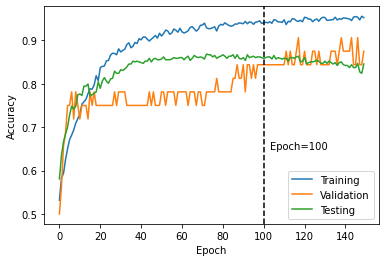

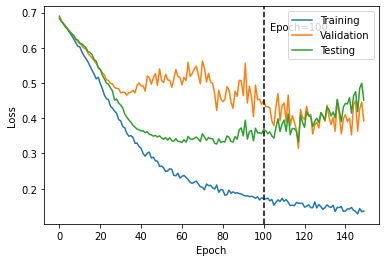

In [50]:
    ##############################################################################
# THIS CODE BLOCK IS SPECIFICALLY FOR GENERATING THE COMBINED YOLOMODEL ACC/LOSS PLOT #
    ##############################################################################

# Testing the performance of the the best performing iteration of model 7
model = YOLOSigmoidModel(IMG_SIZE)
optimizer = torch.optim.Adam(model.parameters())
checkpoint = torch.load(BASE_DIR + '/torch_objects/modelYOLOmoreReLuLast50Epoch.pt', map_location=torch.device('cpu'))

batch_size = 32

train_dataset = XrayDataset('train')
val_dataset = XrayDataset('val')
test_dataset = XrayDataset('test')
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

import matplotlib.pyplot as plt

plt.plot(range(len(checkpoint['train_acc'])), checkpoint['train_acc'], label="Training")
plt.plot(range(len(checkpoint['eval_acc'])), checkpoint['eval_acc'], label="Validation")
plt.plot(range(len(checkpoint['test_acc'])), checkpoint['test_acc'], label="Testing")

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.axvline(x=100, linestyle='--', color='black')
plt.text(103, 0.65, 'Epoch=100')

plt.savefig("YOLOModel_yolo150_acc.png", dpi=1000)
plt.show()


adj_costs = torch.stack([torch.tensor(checkpoint['train_cost']) / len(train_dataloader), torch.tensor(checkpoint['eval_cost']) / len(val_dataloader), torch.tensor(checkpoint['test_cost']) / len(test_dataloader)])
# adj_costs[range(0, 3, 2), 17:] /= 2
length = len(checkpoint['train_cost'])

plt.plot(range(length), adj_costs[0], label="Training")
plt.plot(range(length), adj_costs[1], label="Validation")
plt.plot(range(length), adj_costs[2], label="Testing")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.axvline(x=100, linestyle='--', color='black')
plt.text(103, 0.65, 'Epoch=100')

plt.savefig("YOLOModel_yolo150_loss.png", dpi=1000)
plt.show()